The [Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) is a dataset of features computed from breast mass of candidate patients. Each instance of features corresponds to a malignant or benign tumour. The motivation behind studying this dataset is the develop an algorithm, which would be able to predict whether a patient has a malignant or benign tumour, based on the features computed from her breast mass. I decided to use this dataset for my first blog post on machine learning, since its a very straightforward dataset with no missing values and all variables being real valued (no categorical variables).

* Number of attributes for each patient : 30
* Number of patients : 569
* Number of class labels : 2 ('B' and 'M' corresponding to 357 Benign and 212 Malignant patients)

The scope of this blog post is to get started with using the packages : pandas and scikit-learning, and getting familiar with the general flow of solving a data related machine learning problem. We want to broadly go through the various steps (importing the data, cleaning the data, preprocessing, building models and optimizing them) without going too much in depth with each step. However, I assume you are familiar with the concepts behind Logistic Regression and Neural Networks. If not, [Andrew Ng's Coursera course](https://www.coursera.org/learn/machine-learning/home/welcome) is a great place to start (It's what I used!)

We start by loading our packages, importing the dataset and mapping 'B' and 'M' class labels to integers, and separating the attributes and class labels.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('breast-cancer-wisconsin.data.csv', header=None)
df = df.replace({'B':0, 'M':1})
x = df.iloc[:,2:] 
y = df.iloc[:,1]
print x.shape, y.shape

(569, 30) (569,)


## Normalization

Normalization is a bit of a "controversial" subject (for lack of a better term). I tried to research on this a bit by looking at questions on [stackexchange](https://stats.stackexchange.com/questions/189652/is-it-a-good-practice-to-always-scale-normalize-data-for-machine-learning) and [quora](https://www.quora.com/Should-input-data-to-logistic-regression-be-normalized). If you're using regularization (For those unfamiliar with the term "regularization", Andrew Ng does a good job of explaning it in his lectures on Logistic Regression in the above mentioned course), it makes sense to normalize your input, while at the same time, you should not normalize if you are trying to interpret and explain the coefficients and relate them to the features. Since this post is aimed at being more of an introduction to solving problems using scikit-learn and pandas, I decided to not focus on excessive explorations of coefficients.

In [2]:
x_mean = x.mean()
x_std = x.std()
x_norm = (x - x_mean)/x_std
print x_norm.shape

(569, 30)


## Model 1 - Logistic Regression

We start by using a simple logistic regression model, and use **K fold cross validation** to get the accuracy on the dataset. K fold cross validation is a method used to prevent overfitting (A situation where your model fits the training data too well but does not generalize well enough to data which is outside the training set).

Here, our training data is divided into 5 parts, the prediction model is generated for the 4 parts, and tested on the 5th part. This is done 5 times by using different combinations of these parts as training and test sets, and eventually an average of all these models is used to get the final accuracy.

Find out more about cross validation [here](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) and scikit specific information [here](scikit-learn.org/stable/modules/cross_validation.html)

In [3]:
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn import linear_model
logreg = linear_model.LogisticRegression()
kfold = KFold(n_splits=5,random_state=7)
cv_results = cross_val_score(logreg, x_norm, y, cv=kfold)
print (cv_results.mean()*100, "%")

(97.717745691662799, '%')


So, we can see that using logistic regression gave us an accuracy of **97.7%** on the dataset.

Next, we optimize the parameters of our model. For logistic regression, it makes sense to look at the parameter C, which is the inverse of the regularization parameter. The lower the value of C, the higher we penalize the coefficients of our logistic regression.

In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = {"C":[0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=kfold)
grid.fit(x_norm,y)
print (grid.best_estimator_.C)
print (grid.best_score_*100, "%")

0.1
(97.89103690685414, '%')


As we can see, our accuracy has increased slightly to **97.89%**.

## Plotting the validation curve

Lets now look at the validation curve and confirm that we're not overfitting. For this, we need the individual training score and test scores (here, by test score I mean the average of scores on the 5 validation sets) for each of our 5 "folds", and plot them by varying C. For those values of C which give us a low training and high test score, we have high bias, and our model "underfits" the dataset.

At some point, the test score starts decreasing with increase in value of C, and this is said to be "overfitting" of the dataset (because our model fits the training data too well, but fails to generalize on the test set). The middle ground, where the test score is highest, is the value of C we are looking for.

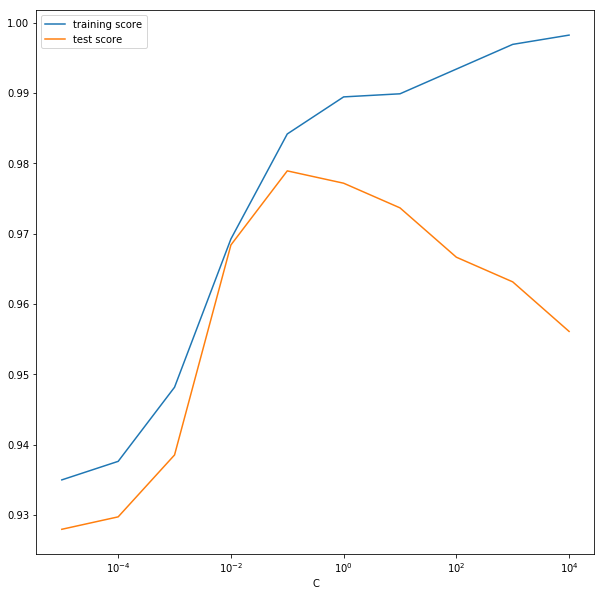

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)
from sklearn.model_selection import validation_curve

num_splits = 5
num_C_values = 10 # we iterate over 10 possible C values
kfold = KFold(n_splits=5,random_state=7)
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
train_scores, valid_scores = validation_curve(logreg, x_norm, y, "C", C_values, cv=kfold)
train_scores = pd.DataFrame(data=train_scores, index=np.arange(0, num_C_values), columns=np.arange(0,num_splits)) 
valid_scores = pd.DataFrame(data=valid_scores, index=np.arange(0, num_C_values), columns=np.arange(0,num_splits)) 
plt.semilogx(C_values, train_scores.mean(axis=1), label='training score')
plt.semilogx(C_values, valid_scores.mean(axis=1), label='test score')
plt.xlabel('C')
plt.legend()

As we can see, the optimum point is at C=0.1, where we get an accuracy of **97.89%**.

## Model 2 - Neural Network

Now we move on to the next classifier - Neural Network. We choose 'lbfgs' solver, which works better on small datasets. For the architecture of the neural network, I decided to use 1 hidden layer (which is the standard for most NN problems).

For the number of hidden units, initially I tried to do this experimentally, I tried 5, 10, 15 and the default for scikit (which is 100). 100 hidden units seemed to be giving the best accuracy. However, such a large number of hidden units is bound to cause overfitting, so I decided to use a "better" method to decide the number of hidden nodes. According to [this](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw) post, the mean of number of input output layers is a good approximation of the number of hidden layers to use. So, let us go ahead with 15 hidden neurons.

In [6]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', random_state=1, activation='logistic', hidden_layer_sizes=(15,))
kfold = KFold(n_splits=5,random_state=7)
cv_results = cross_val_score(clf, x_norm, y, cv=kfold)
print (cv_results.mean()*100, "%")

(96.129482999534233, '%')


On optimizing the parameter "alpha" (regularization parameter for neural network) in a similar way to what we did with the regularization parameter in logistic regression.

In [7]:
clf = MLPClassifier(solver='lbfgs', random_state=1, activation='logistic',  hidden_layer_sizes=(15,))
param_grid = {"alpha":10.0 ** -np.arange(-4, 7)}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kfold)
grid.fit(x_norm,y)
print (grid.best_estimator_)
print (grid.best_score_*100, "%")

MLPClassifier(activation='logistic', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
(97.715289982425318, '%')


Thus, alpha = 1.0 gives an optimal accuracy of **97.7%**.

## Combining the classifiers

Both models (Logistic regression and neural network models) seem to be giving a good accuracy. Lets see the misclassified examples of both models to figure out if we can combine them in some way.

In [8]:
from sklearn.model_selection import cross_val_predict
logreg = linear_model.LogisticRegression(C=0.1)
kfold = KFold(n_splits=5,random_state=7)
cv_results = cross_val_score(logreg, x_norm, y, cv=kfold)
predicted = cross_val_predict(logreg, x_norm, y, cv=kfold)
diff = predicted - y
misclass_indexes = diff[diff != 0].index.tolist()
print (misclass_indexes)

[38, 40, 41, 73, 135, 205, 213, 255, 263, 297, 413, 541]


In [9]:
clf = MLPClassifier(solver='lbfgs', random_state=1, activation='logistic', alpha=1.0, hidden_layer_sizes=(15,))
kfold = KFold(n_splits=5,random_state=7)
cv_results = cross_val_score(clf, x_norm, y, cv=kfold)
predicted = cross_val_predict(clf, x_norm, y, cv=kfold)
diff = predicted - y
misclass_indexes = diff[diff != 0].index.tolist()
print (misclass_indexes)

[38, 40, 68, 73, 135, 190, 213, 215, 263, 297, 363, 413, 541]


9 objects are misclassified by both classifiers, but we can improve the overall accuracy by using a combination of the 2 classfiers and assigning weights. (If we had 3 classifiers we would also have considered a majority voting ensemble). 

I played around a bit with the weights manually, and assigning a weight of 2 to logistic regression and 1 for the neural network gave the best accuracy (although not by a huge margin). While its tempting to relate this with the fact that logistic regression had a slightly better accuracy, and claim that this is a "logical" way to choose the weights, I am pretty sure that assigning the weights in this way is also some sort of "overfitting". The optimization of the classifier weights is beyong the scope of this post, hence we won't go farther on this topic here.

In [10]:
from sklearn.ensemble import VotingClassifier
clf1 = linear_model.LogisticRegression(C=0.1)
clf2 = MLPClassifier(solver='lbfgs', alpha=1.0,hidden_layer_sizes=(15,), random_state=1, activation='logistic')
eclf = VotingClassifier(estimators=[('lr', clf1), ('nn', clf2)], voting='soft', weights=[2,1])
cv_results = cross_val_score(eclf, x_norm, y, cv=kfold)
print (cv_results.mean()*100, "%")

(98.244061481136455, '%')


So, we observe that the combined classifier improves our overall accuracy to **98.24%**

That's it for this post. I learnt a lot while working on this dataset, and I hope it can help you get started in this domain. Any feedback is highly appreciated (whether it be related to the writing of the post or if I made a mistake in the content). 